You'll now extend the MCP chatbot capabilities by making it connect to any MCP server. You will integrate the tools of two official MCP servers in addition to the tools of the research server you built in a previous lesson. 

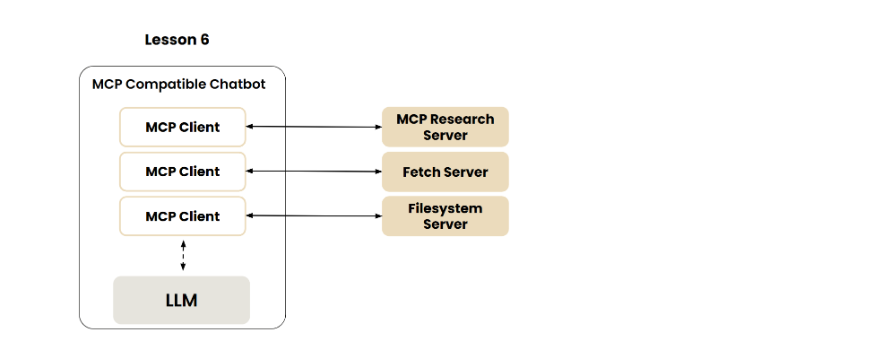

## Open-Source MCP Servers

In this [repo](https://github.com/modelcontextprotocol/servers), you can find a collection of reference implementations for the MCP servers, as well as references to community built servers and additional resources. You will use two of the reference servers to integrate their tools in your MCP chatbot:
- [fetch](https://github.com/modelcontextprotocol/servers/tree/main/src/fetch): provides the `fetch` tool which fetches a URL from the internet and extracts its contents as markdown.
- [filesystem](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem): provides several tools for interacting with the files and directories within a directory that you specify.

You can check the readme file of each server to check the features they expose and how to run them.  

## Updating the MCP Chatbot - Optional Reading

Here are the updates you'll make to the chatbot. You're encouraged to read this section before or after you watch the video, if you'd like to learn more about the details of the code.

- Instead of hardcoding the server parameters in the chatbot, the chatbot will read the server configurations from a JSON file:
  ### Server Configuration
  In the `L6/mcp_project`, you can find the `server_config.json` configuration file that has the following structure.
    ``` json
    {
        "mcpServers": {
            
            "filesystem": {
                "command": "npx",
                "args": [
                    "-y",
                    "@modelcontextprotocol/server-filesystem",
                    "."
                ]
            },
            
            "research": {
                "command": "uv",
                "args": ["run", "research_server.py"]
            },
            
            "fetch": {
                "command": "uvx",
                "args": ["mcp-server-fetch"]
            }
        }
    }
    ```
    For the reference servers, the commands `npx` and `uvx` directly install the files of the servers to your local environment (you don't need to install them ahead of time). Note for the `filesystem`, the `.` is provided as the third argument and it means "current directory". This means that you're allowing for the `fetch` server to interact with the files and directories that are within the current directory.

- Here's a rough sketch of the diagram of the updated MCP_chatbot:
  
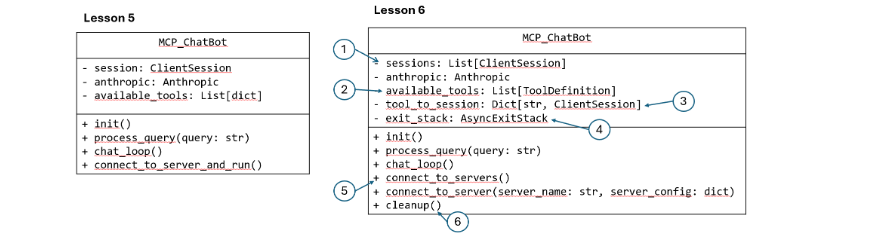

  1. Instead of having one session, you now have a list of client sessions where each client session establishes a 1-to-1 connection to each server;
  2. `available_tools` includes the definitions of all the tools exposed by all servers that the chatbot can connect to.
  3. `tool_to_session` maps the tool name to the corresponding client session; in this way, when the LLM decides on a particular tool name, you can map it to the correct client session so you can use that session to send `tool_call` request to the right MCP server.
  4. `exit_stack` is a context manager that will manage the mcp client objects and their sessions and ensures that they are properly closed. In lesson 5, you did not use it because you used the `with` statement which behind the scenes uses a context manager. Here you could again use the `with` statement, but you may end up using multiple nested `with` statements since you have multiple servers to connect to. `exit_stack` allows you to dynamically add the mcp clients and their sessions as you'll see in the code below.
  5. `connect_to_servers` reads the server configuration file and for each single server, it calls the helper method `connect_to_server`. In this latter method, an MCP client is created and used to launch the server as a sub-process and then a client session is created to connect to the server and get a description of the list of the tools provided by the server.
  6. `cleanup` is a helper method that ensures all your connections are properly shut down when you're done with them. In lesson 5, you relied on the `with` statement to automatically clean up resources. This cleanup method serves a similar purpose, but for all the resources you've added to your exit_stack; it closes (your MCP clients and sessions) in the reverse order they were added - like stacking and unstacking plates. This is particularly important in network programming to avoid resource leaks.

## Updated Code for the MCP Chatbot

In [1]:
%%writefile mcp_project/mcp_chatbot.py

from dotenv import load_dotenv
from anthropic import Anthropic
from mcp import ClientSession, StdioServerParameters, types
from mcp.client.stdio import stdio_client
from typing import List, Dict, TypedDict
from contextlib import AsyncExitStack
import json
import asyncio

load_dotenv()

class ToolDefinition(TypedDict):
    name: str
    description: str
    input_schema: dict

class MCP_ChatBot:

    def __init__(self):
        # Initialize session and client objects
        self.sessions: List[ClientSession] = [] # new
        self.exit_stack = AsyncExitStack() # new
        self.anthropic = Anthropic()
        self.available_tools: List[ToolDefinition] = [] # new
        self.tool_to_session: Dict[str, ClientSession] = {} # new


    async def connect_to_server(self, server_name: str, server_config: dict) -> None:
        """Connect to a single MCP server."""
        try:
            server_params = StdioServerParameters(**server_config)
            stdio_transport = await self.exit_stack.enter_async_context(
                stdio_client(server_params)
            ) # new
            read, write = stdio_transport
            session = await self.exit_stack.enter_async_context(
                ClientSession(read, write)
            ) # new
            await session.initialize()
            self.sessions.append(session)
            
            # List available tools for this session
            response = await session.list_tools()
            tools = response.tools
            print(f"\nConnected to {server_name} with tools:", [t.name for t in tools])
            
            for tool in tools: # new
                self.tool_to_session[tool.name] = session
                self.available_tools.append({
                    "name": tool.name,
                    "description": tool.description,
                    "input_schema": tool.inputSchema
                })
        except Exception as e:
            print(f"Failed to connect to {server_name}: {e}")

    async def connect_to_servers(self): # new
        """Connect to all configured MCP servers."""
        try:
            with open("server_config.json", "r") as file:
                data = json.load(file)
            
            servers = data.get("mcpServers", {})
            
            for server_name, server_config in servers.items():
                await self.connect_to_server(server_name, server_config)
        except Exception as e:
            print(f"Error loading server configuration: {e}")
            raise
    
    async def process_query(self, query):
        messages = [{'role':'user', 'content':query}]
        response = self.anthropic.messages.create(max_tokens = 2024,
                                      model = 'claude-3-7-sonnet-20250219', 
                                      tools = self.available_tools,
                                      messages = messages)
        process_query = True
        while process_query:
            assistant_content = []
            for content in response.content:
                if content.type =='text':
                    print(content.text)
                    assistant_content.append(content)
                    if(len(response.content) == 1):
                        process_query= False
                elif content.type == 'tool_use':
                    assistant_content.append(content)
                    messages.append({'role':'assistant', 'content':assistant_content})
                    tool_id = content.id
                    tool_args = content.input
                    tool_name = content.name
                    
    
                    print(f"Calling tool {tool_name} with args {tool_args}")
                    
                    # Call a tool
                    session = self.tool_to_session[tool_name] # new
                    result = await session.call_tool(tool_name, arguments=tool_args)
                    messages.append({"role": "user", 
                                      "content": [
                                          {
                                              "type": "tool_result",
                                              "tool_use_id":tool_id,
                                              "content": result.content
                                          }
                                      ]
                                    })
                    response = self.anthropic.messages.create(max_tokens = 2024,
                                      model = 'claude-3-7-sonnet-20250219', 
                                      tools = self.available_tools,
                                      messages = messages) 
                    
                    if(len(response.content) == 1 and response.content[0].type == "text"):
                        print(response.content[0].text)
                        process_query= False

    
    
    async def chat_loop(self):
        """Run an interactive chat loop"""
        print("\nMCP Chatbot Started!")
        print("Type your queries or 'quit' to exit.")
        
        while True:
            try:
                query = input("\nQuery: ").strip()
        
                if query.lower() == 'quit':
                    break
                    
                await self.process_query(query)
                print("\n")
                    
            except Exception as e:
                print(f"\nError: {str(e)}")
    
    async def cleanup(self): # new
        """Cleanly close all resources using AsyncExitStack."""
        await self.exit_stack.aclose()


async def main():
    chatbot = MCP_ChatBot()
    try:
        # the mcp clients and sessions are not initialized using "with"
        # like in the previous lesson
        # so the cleanup should be manually handled
        await chatbot.connect_to_servers() # new! 
        await chatbot.chat_loop()
    finally:
        await chatbot.cleanup() #new! 


if __name__ == "__main__":
    asyncio.run(main())

Overwriting mcp_project/mcp_chatbot.py


## Running the MCP Chatbot

**Terminal Instructions**

- To open the terminal, run the cell below.
- Navigate to the `mcp_project` directory:
    - `cd L6/mcp_project`
- Activate the virtual environment:
    - `source .venv/bin/activate`
- Run the chatbot:
    - `uv run mcp_chatbot.py`
- To exit the chatbot, type `quit`.
- If you run some queries and would like to access the `papers` folder or any output files: 1) click on the `File` option on the top menu of the notebook and 2) click on `Open` and then 3) click on `L6` -> `mcp_project`.

In [2]:
# start a new terminal
import os
from IPython.display import IFrame

IFrame(f"{os.environ.get('DLAI_LOCAL_URL').format(port=8888)}terminals/3", width=600, height=768)

Make sure to interact with the chatbot. Here are some query examples:
- Fetch the content of this website: https://modelcontextprotocol.io/docs/concepts/architecture and save the content in the file "mcp_summary.md", create a visual diagram that summarizes the content of "mcp_summary.md" and save it in a text file
- Fetch deeplearning.ai and find an interesting term. Search for 2 papers around the term and then summarize your findings and write them to a file called results.txt

## Final Notes

You are encouraged to refactor the code of `MCP_ChatBot` if you'd like:

- how to connect to servers asynchronously
- what if tools from different servers have the same name
- revisit the attributes
  
And maybe any other idea you may think of.